In [1]:
# Import all the Dependencies
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [2]:
# Set all the Constants
INIT_LR = 1e-3
BATCH_SIZE = 32
#for now changing from 50 to 10, the number times that the learning algorithm will work through the entire training dataset
EPOCHS = 10
IMAGE_SIZE = 256
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
data_dir = "PlantVillage"
CHANNELS=3
AUTOTUNE = tf.data.AUTOTUNE

In [14]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
        'dataset/train',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode='sparse',
)

Found 1506 images belonging to 3 classes.


In [4]:
## Initializing, Exploring & Partioning the Dataset

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = ds.cardinality().numpy()
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


#Reading and Partitioning the Dataset
We create a Tensorflow Dataset Object and directly read it from the directory using `image_dataset_from_directory` and then split it using the function we created above

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=default_image_size,
  batch_size=BATCH_SIZE
)


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
n_classes = len(class_names)
print(n_classes, class_names)

3 ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


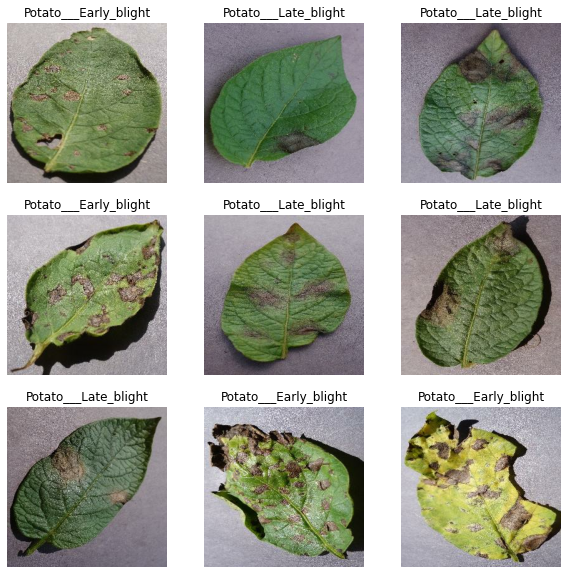

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [16]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [11]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [15]:
count=0
for image_batch, label_batch in train_generator:
#     print(label_batch)
    print(image_batch[0])
    break

[[[0.67420655 0.6467556  0.6781281 ]
  [0.67408687 0.6466359  0.67800844]
  [0.6734326  0.6459816  0.67735416]
  ...
  [0.6392157  0.6156863  0.67058825]
  [0.6390636  0.6155342  0.67043614]
  [0.6351425  0.6116131  0.66651505]]

 [[0.67074037 0.6432894  0.67466193]
  [0.6708002  0.64334923 0.6747218 ]
  [0.67020583 0.64275485 0.6741274 ]
  ...
  [0.6392157  0.6156863  0.67058825]
  [0.63900375 0.61547434 0.6703763 ]
  [0.6350826  0.6115532  0.66645515]]

 [[0.6555122  0.62806123 0.6594338 ]
  [0.6557517  0.6283007  0.6596733 ]
  [0.6552172  0.6277662  0.65913874]
  ...
  [0.6392157  0.6156863  0.67058825]
  [0.6389892  0.6154598  0.67036176]
  [0.63557583 0.6120464  0.6669484 ]]

 ...

 [[0.44497934 0.3861558  0.4136068 ]
  [0.44811824 0.38929468 0.4167457 ]
  [0.46433234 0.40550882 0.4329598 ]
  ...
  [0.46565816 0.41467774 0.45389345]
  [0.465817   0.41483662 0.4540523 ]
  [0.4660565  0.4150761  0.4542918 ]]

 [[0.44356027 0.38473675 0.41218773]
  [0.44684687 0.38802335 0.41547433]


Checking what is the expected dimension order for channel

In [11]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

In [12]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    #filter layer 32(trial error), 3x3 grid, relu-fast computation, input-256x256
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    #3,3 to 2,2 takes max
    layers.MaxPooling2D((2, 2)),
    #trial with 64
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    #pooling again
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    #flatten the layers to array of neurons
    layers.Flatten(),
    
    layers.Dense(64, activation='relu'),
    #3 classes, softmax-used for probability distribution of event over n classes
    layers.Dense(n_classes, activation='softmax'),
])

#api
model.build(input_shape=batch_input_shape)

# model = models.Sequential([
#     layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(n_classes, activation='softmax'),   
# ])
# model.build(input_shape=batch_input_shape)

### Model Summary

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
### Training the Network
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1, #produces lots of logging output
    epochs=EPOCHS,#the number times that the learning algorithm will work through the entire training dataset
)

Epoch 1/10
54/54 [==============================] - 76s 1s/step - loss: 0.9088 - accuracy: 0.4806 - val_loss: 0.8781 - val_accuracy: 0.4635
Epoch 2/10
54/54 [==============================] - 68s 1s/step - loss: 0.8053 - accuracy: 0.6050 - val_loss: 0.5856 - val_accuracy: 0.8177
Epoch 3/10
54/54 [==============================] - 73s 1s/step - loss: 0.5564 - accuracy: 0.7993 - val_loss: 0.4745 - val_accuracy: 0.8073
Epoch 4/10
54/54 [==============================] - 68s 1s/step - loss: 0.4134 - accuracy: 0.8316 - val_loss: 0.3443 - val_accuracy: 0.8646
Epoch 5/10
54/54 [==============================] - 73s 1s/step - loss: 0.4160 - accuracy: 0.8304 - val_loss: 0.3992 - val_accuracy: 0.8802
Epoch 6/10
54/54 [==============================] - 81s 2s/step - loss: 0.3226 - accuracy: 0.8709 - val_loss: 0.2223 - val_accuracy: 0.9167
Epoch 7/10
54/54 [==============================] - 73s 1s/step - loss: 0.2761 - accuracy: 0.8961 - val_loss: 0.2982 - val_accuracy: 0.8542
Epoch 8/10
54/54 [==

In [16]:
# Testing the model
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
8/8 [==============================] - 4s 329ms/step - loss: 0.2207 - accuracy: 0.9180
Test Accuracy: 91.8%


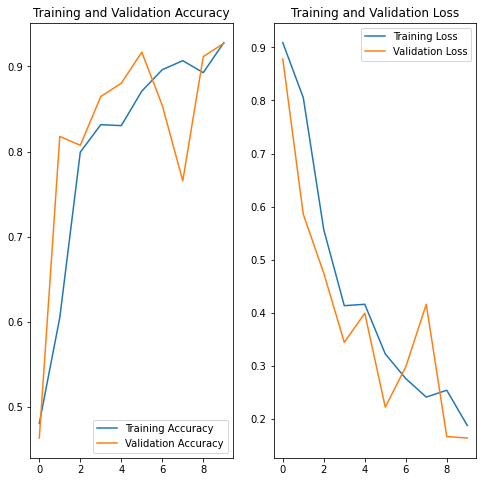

In [17]:
# Plotting the accuracy and Loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
#Saving the Model
#We append the model to the list of models as a new version this will auto increment our model versions 
#import os
#model_version = max([int(i) for i in (os.listdir("../saved_models")+[0])]) + 1
#model.save(f"../saved_models/{model_version}")

model_version = 1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/1\assets


INFO:tensorflow:Assets written to: ../saved_models/1\assets


# Function for inference

 the process of running data points into a machine learning model to calculate an output such as a single numerical score


In [19]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2) #parameter 1st is array and 2nd is-round off till decimal 2
    return predicted_class, confidence

# Plotting the Inference Data

1/1 [==============================] - 0s 29ms/step


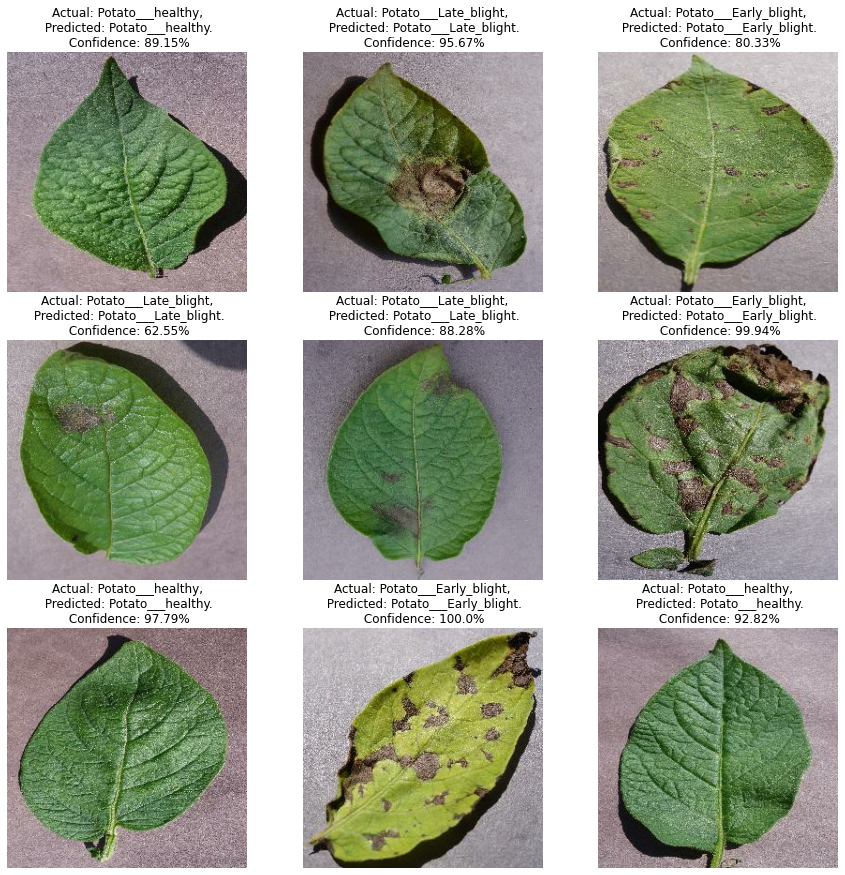

In [20]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")